In [1]:
# My standard opening cell
    
from IPython.core.display import display, HTML
display(HTML('<style>.container { width:95% !important; }</style>'))
   
from matplotlib import pyplot as plt
from matplotlib import cm,colors
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import scipy as sp
import pickle

import treegp
import treecorr
import piff
from astropy.io import fits
from sklearn import neighbors
#import ROOT

%matplotlib notebook

In [2]:
print(treegp.__file__)
print(treegp.__version__)

/u/ec/roodman/.local/lib/python3.7/site-packages/treegp/__init__.py
0.3.0


# Get sample data

In [3]:
# load reference wavefront

rwfile = '/u/ec/roodman/Astrophysics/Donuts/ComboMeshesZemaxIteration2v22/Science-20140212s2-v22i2.fits'
hdu = fits.open(rwfile)
hdu.info()
print(hdu[1].columns)
table = hdu[1].data

Filename: /u/ec/roodman/Astrophysics/Donuts/ComboMeshesZemaxIteration2v22/Science-20140212s2-v22i2.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1                1 BinTableHDU     68   459189R x 30C   [K, D, D, D, D, D, D, D, D, D, D, J, J, 3A, D, D, D, K, K, 30A, D, D, D, D, D, D, D, D, D, D]   
ColDefs(
    name = 'index'; format = 'K'
    name = 'z4raw'; format = 'D'
    name = 'z5'; format = 'D'
    name = 'z6'; format = 'D'
    name = 'z7'; format = 'D'
    name = 'z8'; format = 'D'
    name = 'z9'; format = 'D'
    name = 'z10'; format = 'D'
    name = 'z11'; format = 'D'
    name = 'z14'; format = 'D'
    name = 'z15'; format = 'D'
    name = 'x'; format = 'J'
    name = 'y'; format = 'J'
    name = 'chip'; format = '3A'
    name = 'focal_x'; format = 'D'
    name = 'focal_y'; format = 'D'
    name = 'z4'; format = 'D'
    name = 'ccdnum'; format = 'K'
    name = 'chipnum'; format = 'K'
    name = 'expid';

<IPython.core.display.Javascript object>


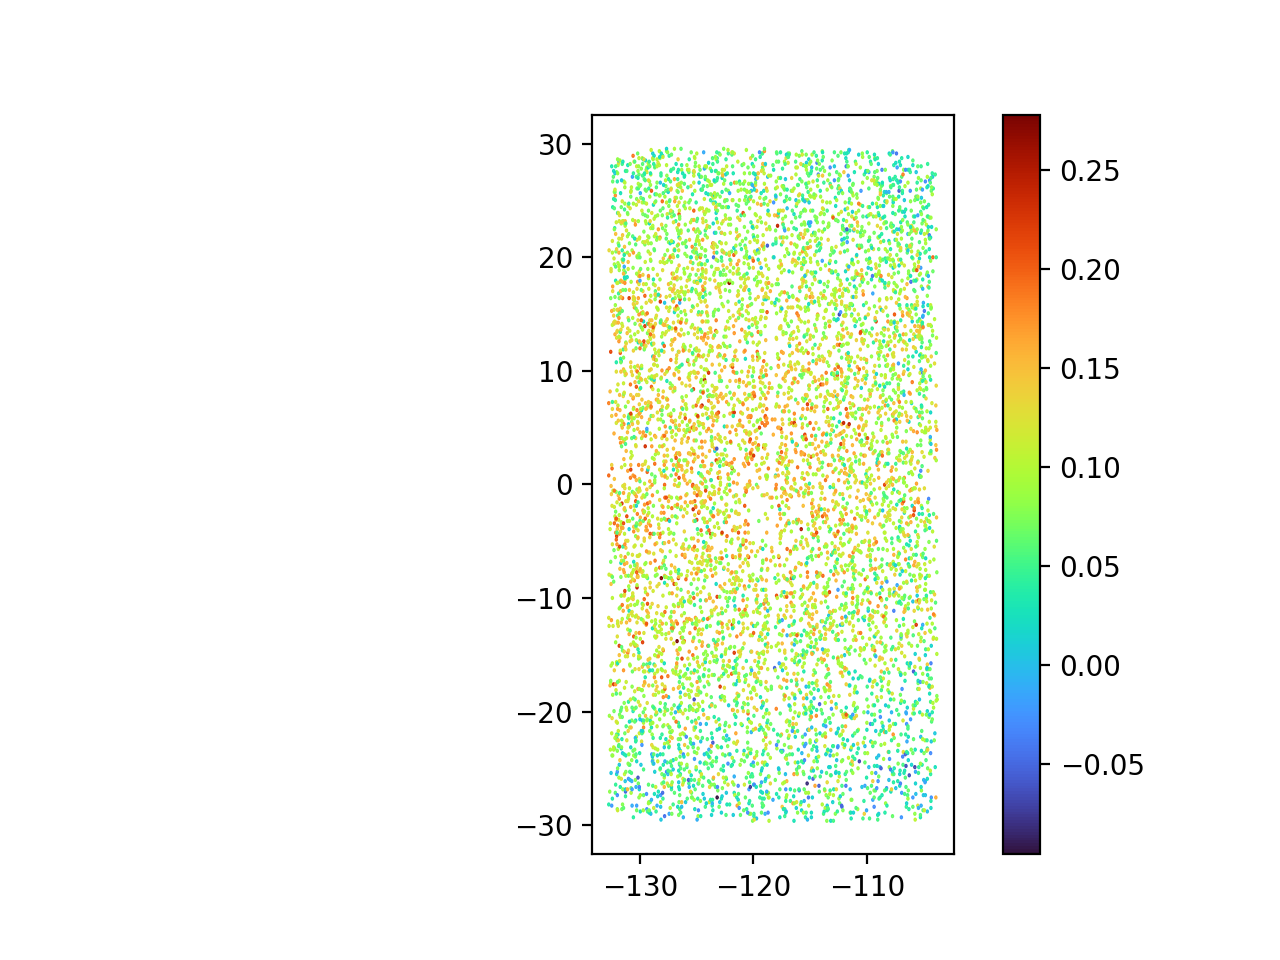

In [4]:
f,ax = plt.subplots(1,1)
table10 = table[(table['chipnum']==10)]
h = ax.hexbin(table10['focal_x'],table10['focal_y'],table10['z4'],gridsize=500,cmap=cm.turbo)
plt.colorbar(h,ax=ax)
ax.set_aspect('equal')

In [5]:
# build the data vectors - reserve some points for testing
testfrac = 0.2
ndonuts = table10['focal_x'].shape[0]
print(ndonuts)

rng = np.random.default_rng(12345)
rvals = rng.uniform(low=0., high=1., size=ndonuts)
oktrain = (rvals>testfrac)

Xtrain = np.column_stack((table10['focal_x'][oktrain],table10['focal_y'][oktrain]))
ytrain = table10['z4'][oktrain]

Xtest = np.column_stack((table10['focal_x'][~oktrain],table10['focal_y'][~oktrain]))
ytest = table10['z4'][~oktrain]

7789


In [6]:
# build a grid of points to test smoothing
chipnum = 10 
nx, ny = (32, 64)
chipnums = chipnum*np.ones((nx*ny))
ixs = np.linspace(0, 2048, nx)
iys = np.linspace(0, 4096, ny)
ix,iy = np.meshgrid(ixs, iys)
shape = ix.shape
decaminfo = piff.des.DECamInfo()    
fx,fy = decaminfo.getPosition_chipnum(chipnums, ix.flatten(), iy.flatten()) 
inX = np.column_stack((fx,fy))


# KNN smoothing

In [7]:
knn_A = neighbors.KNeighborsRegressor(n_neighbors=150, weights='distance')
knn_regressor_A = knn_A.fit(Xtrain, ytrain)
ygrid_A = knn_regressor_A.predict(inX)
ygrid_A = ygrid_A.reshape(shape)

ytest_A = knn_regressor_A.predict(Xtest)

In [8]:
knn_B = neighbors.KNeighborsRegressor(n_neighbors=10, weights='distance')
knn_regressor_B = knn_B.fit(Xtrain, ytrain)
ygrid_B = knn_regressor_B.predict(inX)
ygrid_B = ygrid_B.reshape(shape)

ytest_B = knn_regressor_B.predict(Xtest)

<IPython.core.display.Javascript object>


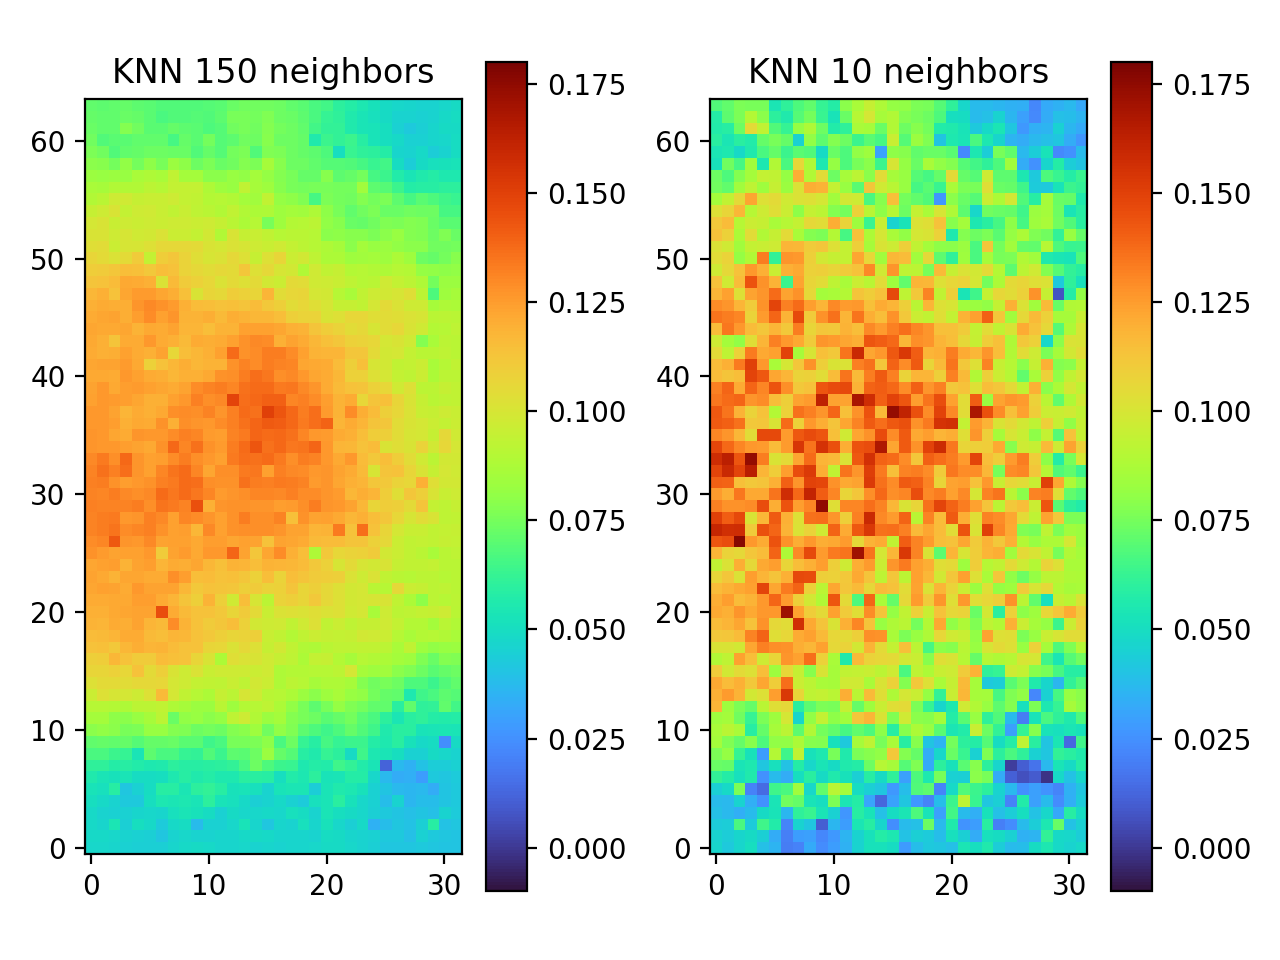

In [9]:
f,ax = plt.subplots(1,2)
h0 = ax[0].imshow(ygrid_A,interpolation='None',origin='lower',cmap=cm.turbo,vmin=-0.01,vmax=0.18)
plt.colorbar(h0,ax=ax[0])
h1 = ax[1].imshow(ygrid_B,interpolation='None',origin='lower',cmap=cm.turbo,vmin=-0.01,vmax=0.18)
plt.colorbar(h1,ax=ax[1])
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
ax[0].set_title('KNN 150 neighbors')
ax[1].set_title('KNN 10 neighbors')
f.tight_layout()

# GP smoothing

In [91]:
print(np.std(ytrain))

0.04947301938390622


In [107]:
kernel = '%f**2 * RBF(20)'%(np.std(ytrain))

gp = treegp.GPInterpolation(kernel=kernel, optimizer='two-pcf', normalize=True, 
                            nbins=30, min_sep=2., max_sep=20.)
gp.initialize(Xtrain, ytrain, y_err=None)
gp.solve()

<IPython.core.display.Javascript object>


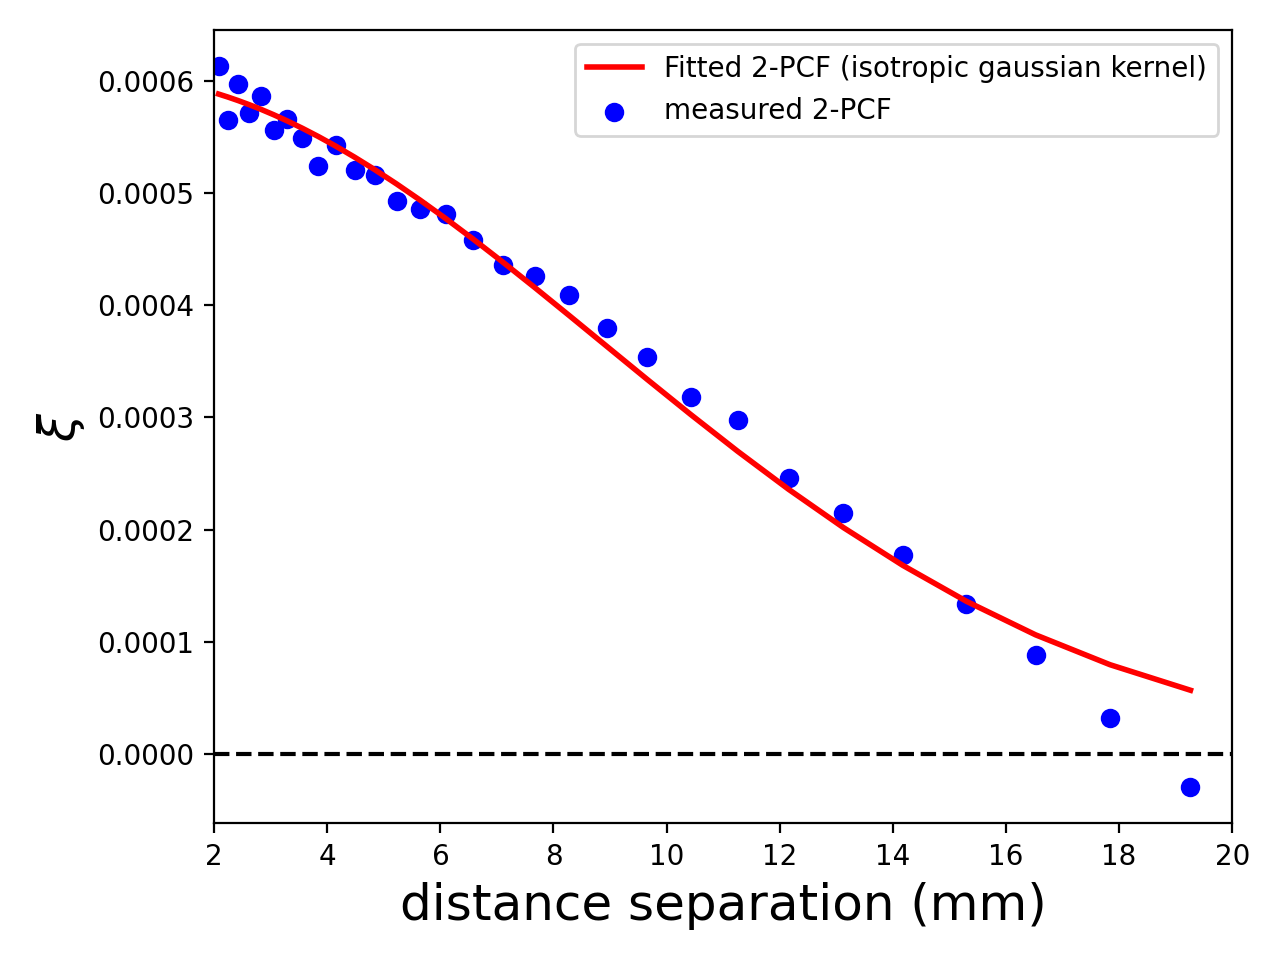

In [108]:
XMIN = 2
XMAX = 20
f,ax = plt.subplots(1,1)
ax.scatter(gp._optimizer._2pcf_dist, gp._optimizer._2pcf, c='b', label='measured 2-PCF')
ax.plot(gp._optimizer._2pcf_dist,gp._optimizer._2pcf_fit, 'r', lw=2, label='Fitted 2-PCF (isotropic gaussian kernel)')
ax.plot([XMIN, XMAX], [0,0], 'k--')
ax.set_xlim(XMIN, XMAX)
ax.set_ylabel('$\\xi$', fontsize=18)
ax.set_xlabel('distance separation (mm)', fontsize=18)
ax.legend()
f.tight_layout()

In [109]:
# get errors from DonutAna pickle file, just use first file as representative of the errors
#d = pickle.load(open("/u/ec/roodman/Astrophysics/Donuts/ComboMeshesZemaxIteration2v22/Science-20140212s2-v22i2_All.pickle",'rb'))
#z4err = d[284601]['z4ResultDict']['rmsDeltaAfter'] * (8.7/1500.)   #conversion only needed for z4, from micron to waves
z4err = 0.05028244680264905

In [110]:
print("Z4 RMS = ",z4err)

Z4 RMS =  0.05028244680264905


In [111]:
#white_noise = np.sqrt(np.var(y) - np.exp(gp.kernel.theta[0]))
gp._y_err = np.ones_like(gp._y_err) * z4err
print(gp._y_err[0])

0.05028244680264905


In [112]:
ygrid_gp = gp.predict(inX, return_cov=False)

In [113]:
yimage_gp = ygrid_gp.reshape(shape)

<IPython.core.display.Javascript object>


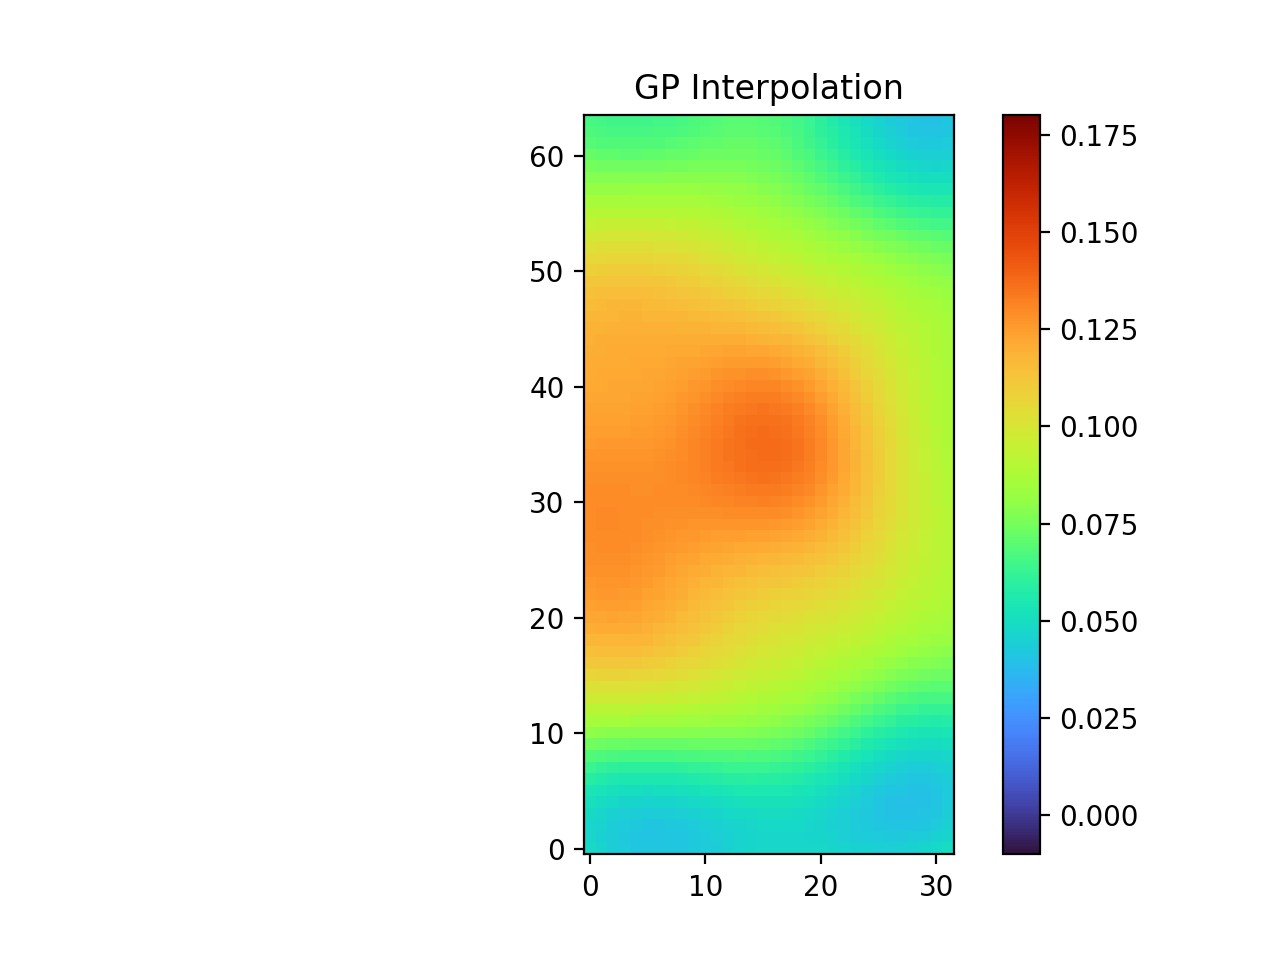

Text(0.5, 1.0, 'GP Interpolation')

In [114]:
f,ax = plt.subplots(1,1)

h = ax.imshow(yimage_gp,interpolation='None',origin='lower',cmap=cm.turbo,vmin=-0.01,vmax=0.18)
plt.colorbar(h,ax=ax)
ax.set_aspect('equal')
ax.set_title("GP Interpolation")

In [115]:
ytest_gp = gp.predict(Xtest, return_cov=False)

# compare results at Test points

<IPython.core.display.Javascript object>


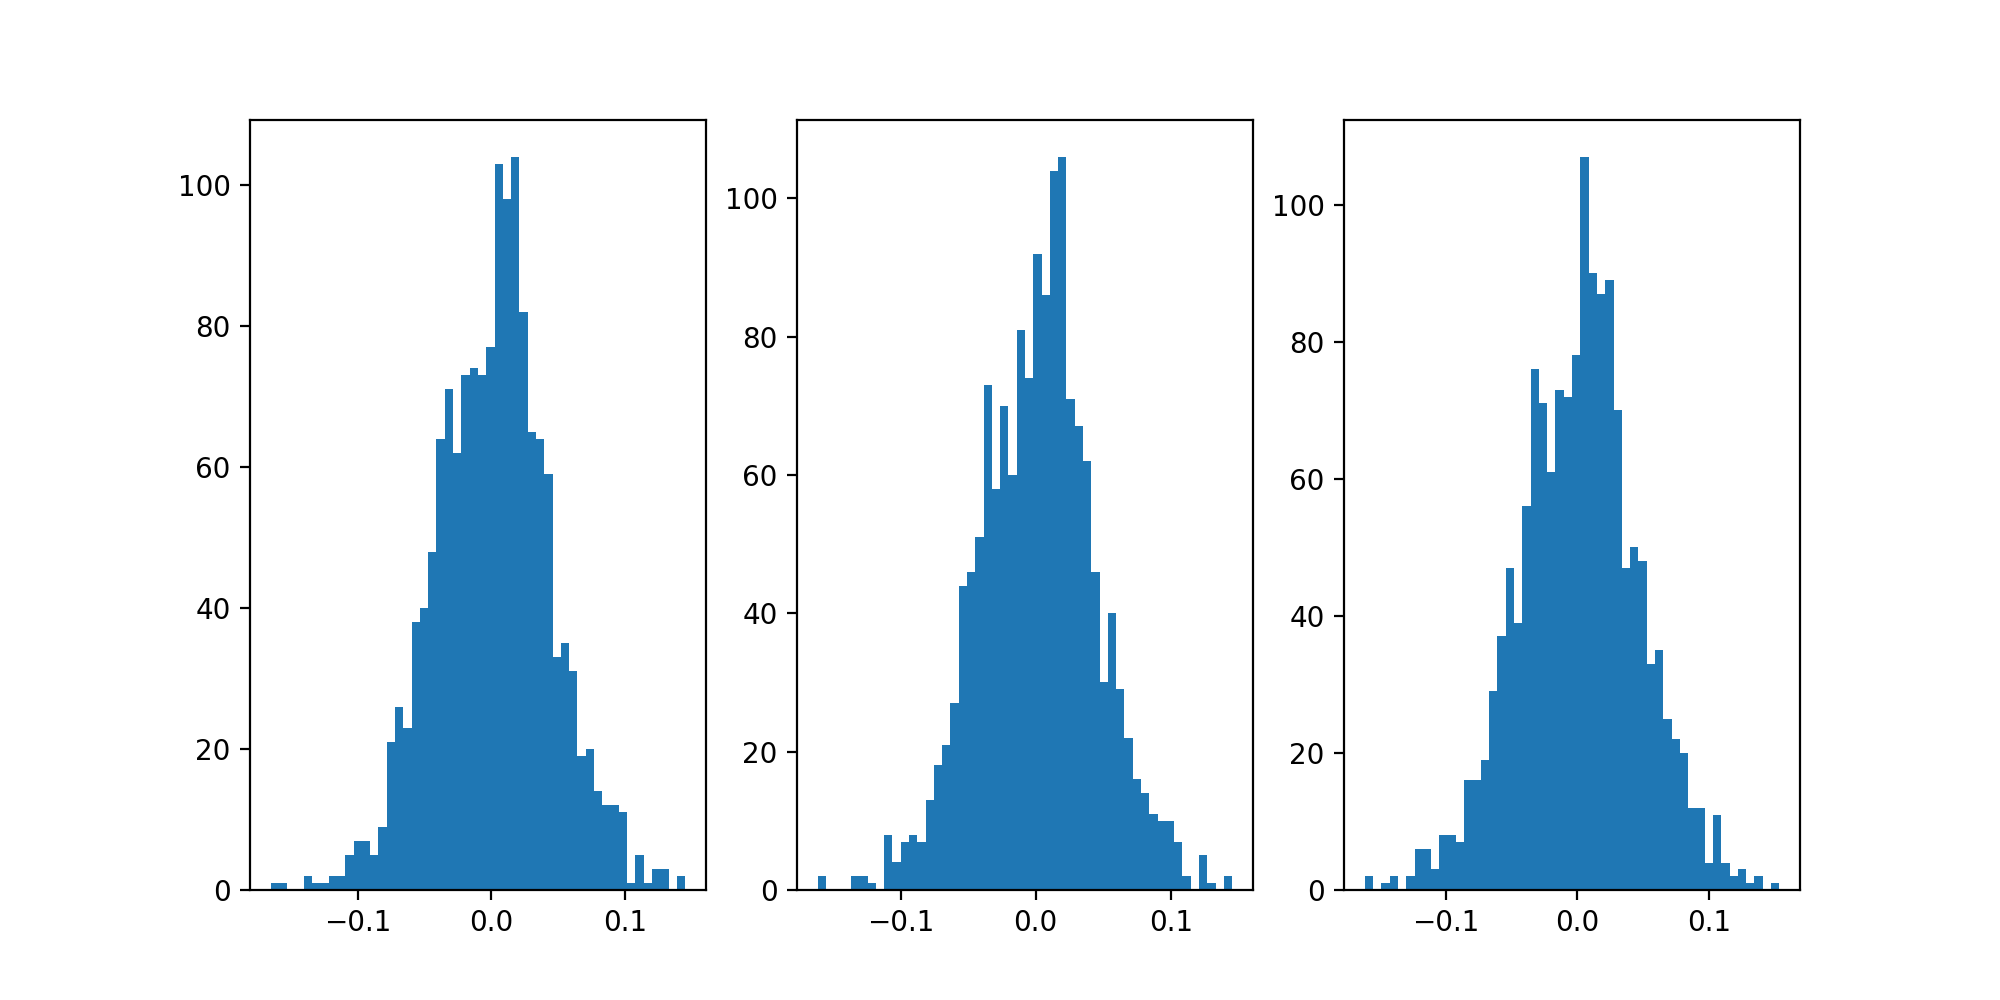

In [116]:
f,ax = plt.subplots(1,3,figsize=(10,5))
h0 = ax[0].hist(ytest_gp-ytest,bins=50)
h1 = ax[1].hist(ytest_A-ytest,bins=50)
h2 = ax[2].hist(ytest_B-ytest,bins=50)

<IPython.core.display.Javascript object>


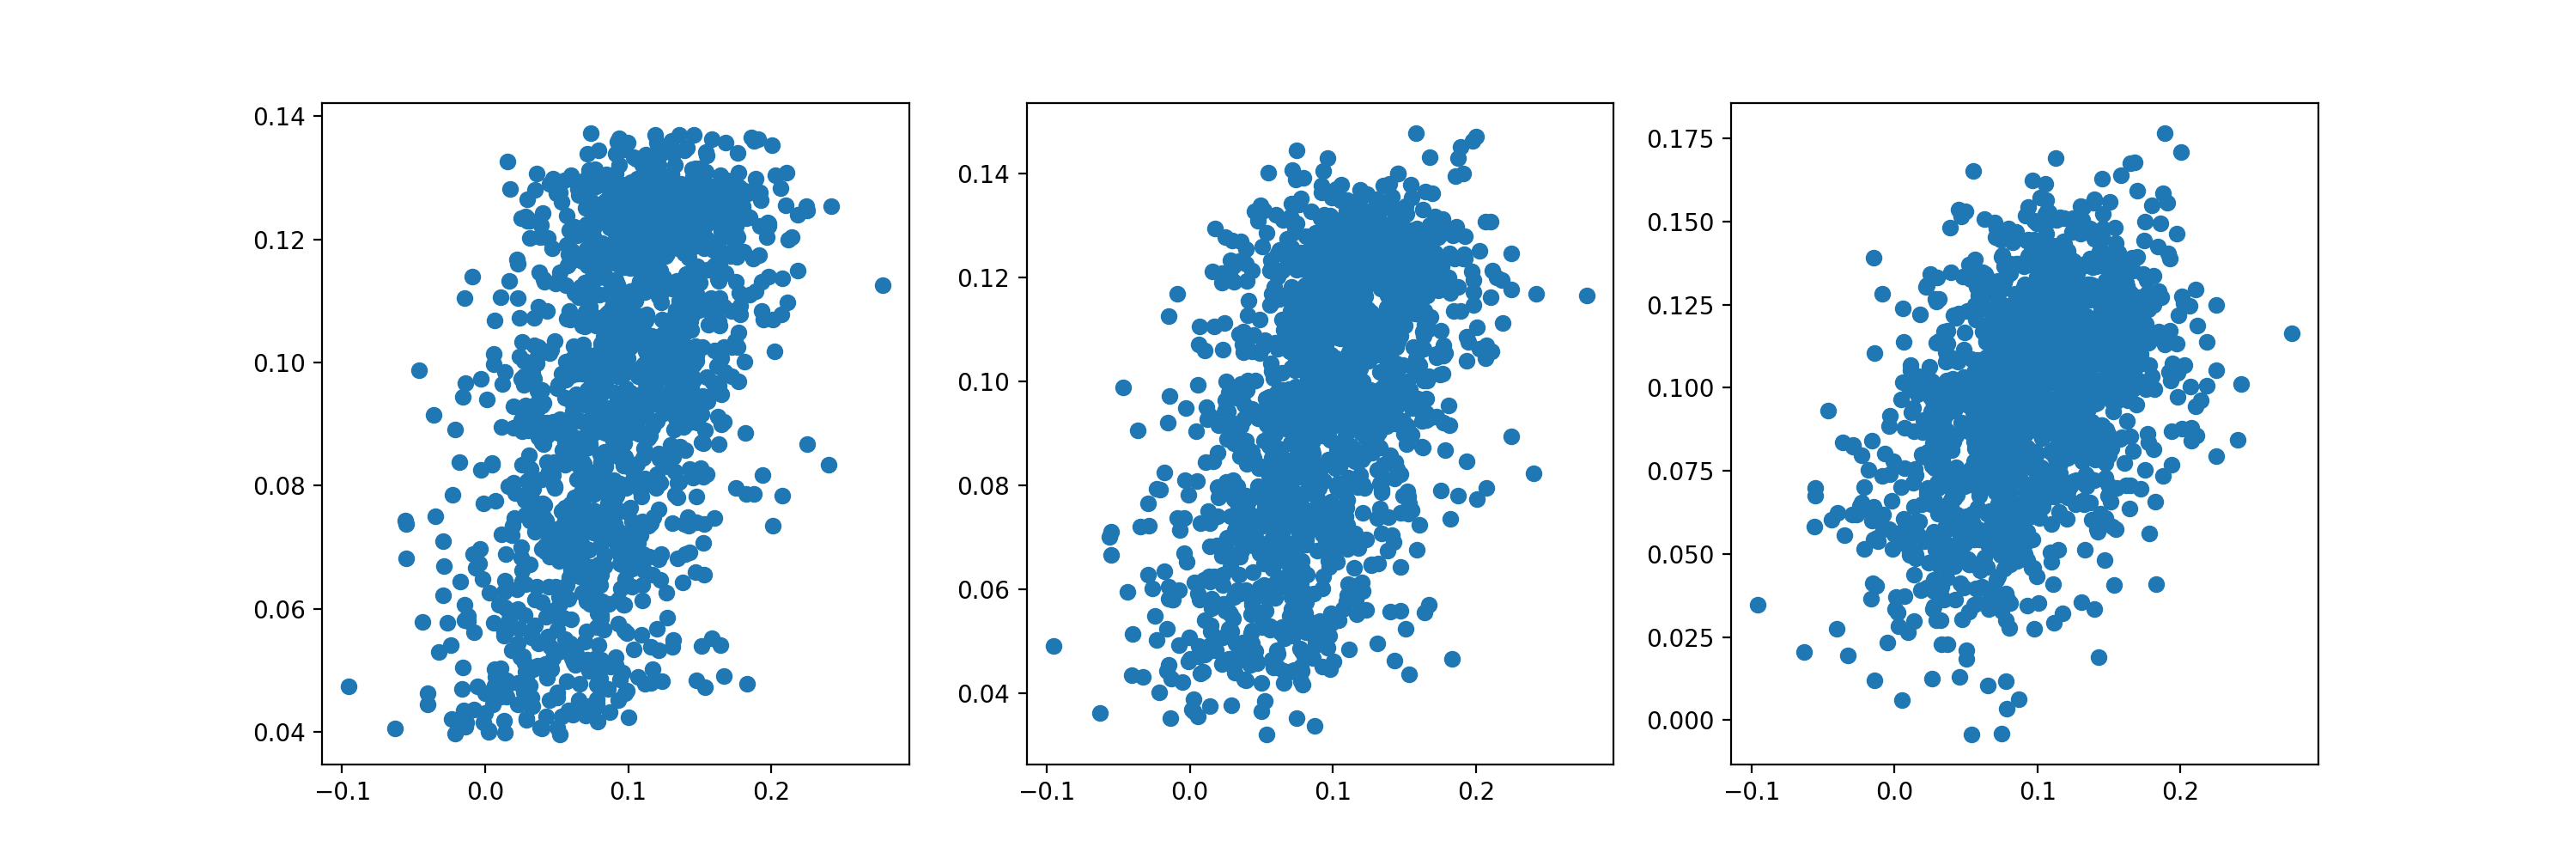

In [117]:
f,ax = plt.subplots(1,3,figsize=(15,5))
h0 = ax[0].scatter(ytest,ytest_gp)
h0 = ax[1].scatter(ytest,ytest_A)
h0 = ax[2].scatter(ytest,ytest_B)

In [118]:
# calculate the mean,rms of the difference and the correlation coeff
print("GP: mean,rms,corrcoef %.5f %.4f %.3f" % (np.mean(ytest_gp-ytest),np.std(ytest_gp-ytest),sp.stats.pearsonr(ytest,ytest_gp)[0]))
print("KNN 150: mean,rms,corrcoef %.5f %.4f %.3f" %(np.mean(ytest_A-ytest),np.std(ytest_A-ytest),sp.stats.pearsonr(ytest,ytest_A)[0]))
print("KNN 10: mean,rms,corrcoef %.5f %.4f %.3f" %(np.mean(ytest_B-ytest),np.std(ytest_B-ytest),sp.stats.pearsonr(ytest,ytest_B)[0]))

GP: mean,rms,corrcoef 0.00140 0.0431 0.489
KNN 150: mean,rms,corrcoef 0.00163 0.0432 0.488
KNN 10: mean,rms,corrcoef 0.00148 0.0457 0.424


GP provides a much smoother interpolation than KNN 150, but with similar results in a set of test points in terms of RMS and CorrCoeff.  However, there is plenty of noise in these measurements which dominates these comparisons. KNN 10, used so far in optatmo, has far too much inhomogeneity - the measurement noise is leaking through

# Compare via 2pcf of residuals

In [119]:
def comp_xi_residuals(inX, Y, Y_err, min_sep=0.1, max_sep=3, nbins=20):
    w = 1./Y_err**2
    cat = treecorr.Catalog(x=inX[:,0], y=inX[:,1], k=(Y-np.mean(Y)), w=w)
    kk = treecorr.KKCorrelation(min_sep=min_sep, max_sep=max_sep, nbins=nbins)
    kk.process(cat)
    distance = kk.meanr
    xi = kk.xi
    return distance, xi



In [126]:
y_err = z4err * np.ones(ytest.shape[0])
dist, xi_gp_residuals =comp_xi_residuals(Xtest,  ytest - ytest_gp, y_err, min_sep=1.0, max_sep=25., nbins=20)
dist, xi_knnA_residuals =comp_xi_residuals(Xtest, ytest - ytest_A, y_err, min_sep=1.0, max_sep=25., nbins=20)
dist, xi_knnB_residuals =comp_xi_residuals(Xtest, ytest - ytest_B, y_err, min_sep=1.0, max_sep=25., nbins=20)

<IPython.core.display.Javascript object>


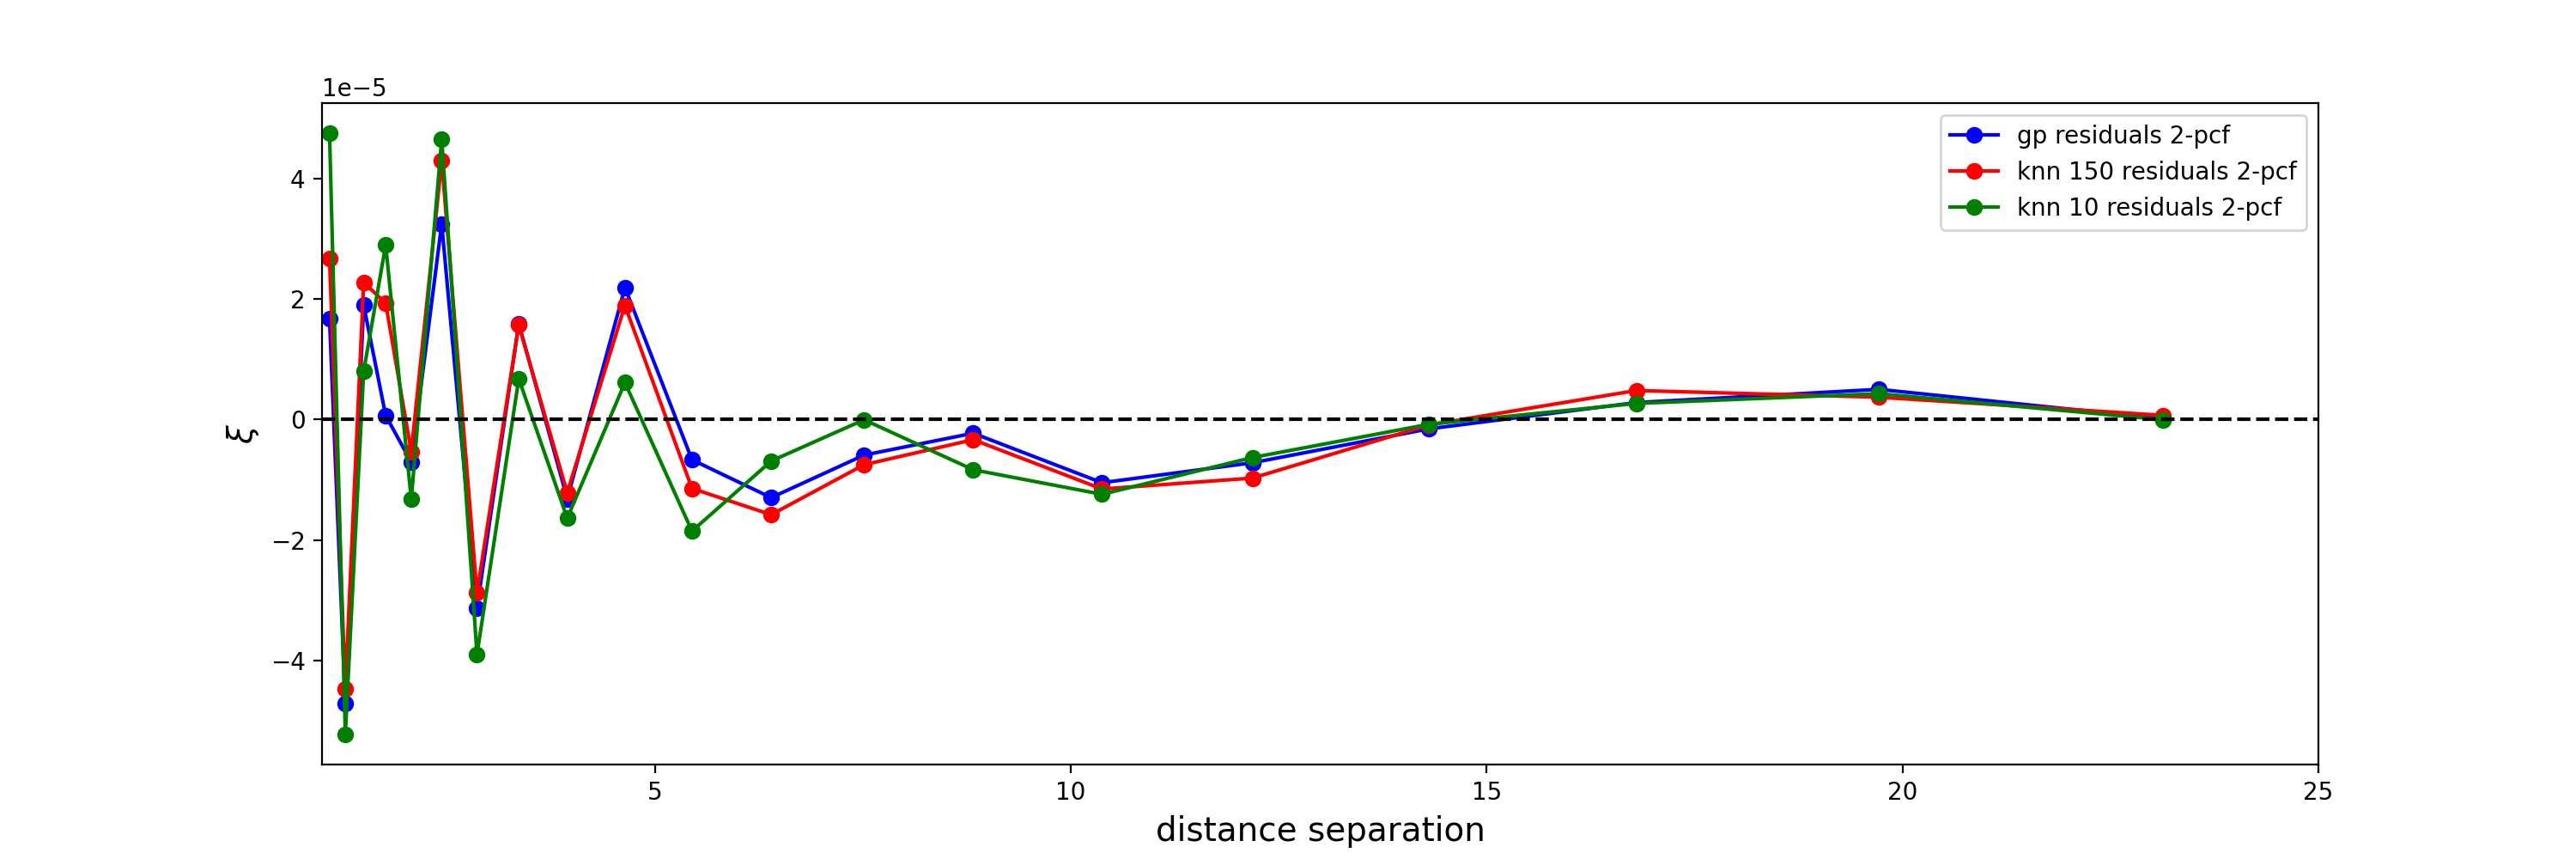

In [127]:
f,ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(dist, xi_gp_residuals, '-o', c='b', label = 'gp residuals 2-pcf')
ax.plot(dist, xi_knnA_residuals, '-o',c='r', label = 'knn 150 residuals 2-pcf')
ax.plot(dist, xi_knnB_residuals, '-o',c='g', label = 'knn 10 residuals 2-pcf')
ax.plot([1.,25.],[0,0], 'k--')
ax.set_xlim(1.,25.)
ax.set_ylabel('$\\xi$', fontsize=14)
ax.set_xlabel('distance separation', fontsize=14)
ax.legend()

Note that the results depend only very very weakly on the length scale passed to RBF.  Also note that in terms of the rho_1 2pcf above, the results for the GP are really only slightly better than the KNN 150 case.